# SeedTag Coding Test

## Introduction 
For this coding test, we are presented with 3 tasks which essentially consist of:
- **Task 1:** Image classification
- **Task 2:** Transfer learning 
- **Task 3:** Unsupervised Learning / Image clustering


# Task 1

In this task, we are provided with the Street View House Numbers (SVHN) dataset. The SVHN dataset, consists of a set of 32x32 RGB images taken from street house numbers, from different angles, light exposures, and with different fonts. Each image is accompanied by a numerical label ranging from 1 to 10, whereby 10 corresponds to the number 0. In this task, the dataset is divided in a training and test set consisting of ~73k and ~6.5k samples respectively. The purpose of this task is to create a model capable of maximizing classification accuracies. 


Firstly, we import the necessary libraries that we will use accross the notebook.

In [1]:
import torchvision
import torch
import os 
import json

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import scipy.io as sio
import numpy as np
import torch.nn as nn
from pytorch_lightning import loggers as pl_loggers
import pytorch_lightning as pl
import torch.nn.utils.prune as prune
import torchvision.transforms as transforms
import scipy.io as sio
import pandas as pd
import seaborn as sns

from torch.utils.data import Dataset
from PIL import Image
from time import time
from  torch.utils.data import DataLoader
import torchmetrics
from sklearn.metrics import accuracy_score


Secondly, we leverage the dataset loading function, and the Dataset class provided in the example.

In [2]:
def load_data(root_dir, split):
    """load_data Load images from the dataset

    Args:
        root_dir (string): root directory 
        split (string): type of split based on the task  

    Returns:
        tuple: set of images and lables
    """
    
    filename = os.path.join(root_dir,'test_32x32.mat')
    if(split.startswith('train') or split.startswith('unlabelled')):
        filename = os.path.join(root_dir,'train_32x32.mat') 
    elif(split.startswith('test')):
        filename = os.path.join(root_dir,'test_32x32.mat')
    
    # Load matrix
    loaded_mat = sio.loadmat(filename)
    
    # Parse images and normalize
    imgs = (loaded_mat['X']/255).astype(np.float32)
    
    # Parse labels, convert to int and create vector
    labels = loaded_mat['y'].astype(np.int64).squeeze()
    
    
    if(split=='train_29_task2'):
        imgs_idx_01 =  np.logical_or(labels==10,labels==1)
        imgs_idx_29 = np.where(np.logical_not(imgs_idx_01))
        imgs = imgs[:,:,:,imgs_idx_29]
        labels = labels[imgs_idx_29]
    elif(split=='test_01_task2' or split=='train_01_task2'):
        imgs_idx_01 =  np.where(np.logical_or(labels==10,labels==1))[0]
        if(split=='train_01_task2'):
            imgs_idx_01 = imgs_idx_01[0:200]
        else:
            imgs_idx_01 = imgs_idx_01[200::]
        imgs = imgs[:,:,:,imgs_idx_01]
        labels = labels[imgs_idx_01]
    if(split=='test_task3'):
        N = 50
        imgs = imgs[:,:,:,0:N]
        labels = labels[0:N]
    print('Loaded SVHN split: {split}'.format(split=split))
    print('-------------------------------------')
    print('Images Size: ' , imgs.shape[0:-1])
    print('Split Number of Images:', imgs.shape[-1])
    print('Split Labels Array Size:', labels.shape)
    print('Possible Labels: ', np.unique(labels))
    return imgs,labels

def eval_model(model,loader):
    model.eval()
    y_pred_list, targets_list = [], []
    for (imgs, targets) in  loader:
        y_pred = model(imgs)
        _,y_pred_label = torch.max(y_pred, dim=1)
        y_pred_list += y_pred_label.detach().numpy().tolist()
        targets_list += targets.detach().numpy().tolist()    
    return(accuracy_score(targets_list, y_pred_list))


class SVHNDataset(Dataset):
    """SVHNDataset SVHN Dataset class to parse images and targets

    Args:
        Dataset (Dataset): None
    """

    def __init__(self, 
                 root_dir, 
                 split, 
                 transform=None):
        self.images, self.labels = load_data(root_dir, split)
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img, target = self.images[:,:,:,index], int(self.labels[index])
        if self.transform:
            img = self.transform(img)
        return img, target-1 # target -1 assuming that there are no 0s

### Data Exploration

Before diving into classification, we will visualize some of the images and understand how labels are distributed.

Loaded SVHN split: test_01_task1
-------------------------------------
Images Size:  (32, 32, 3)
Split Number of Images: 26032
Split Labels Array Size: (26032,)
Possible Labels:  [ 1  2  3  4  5  6  7  8  9 10]


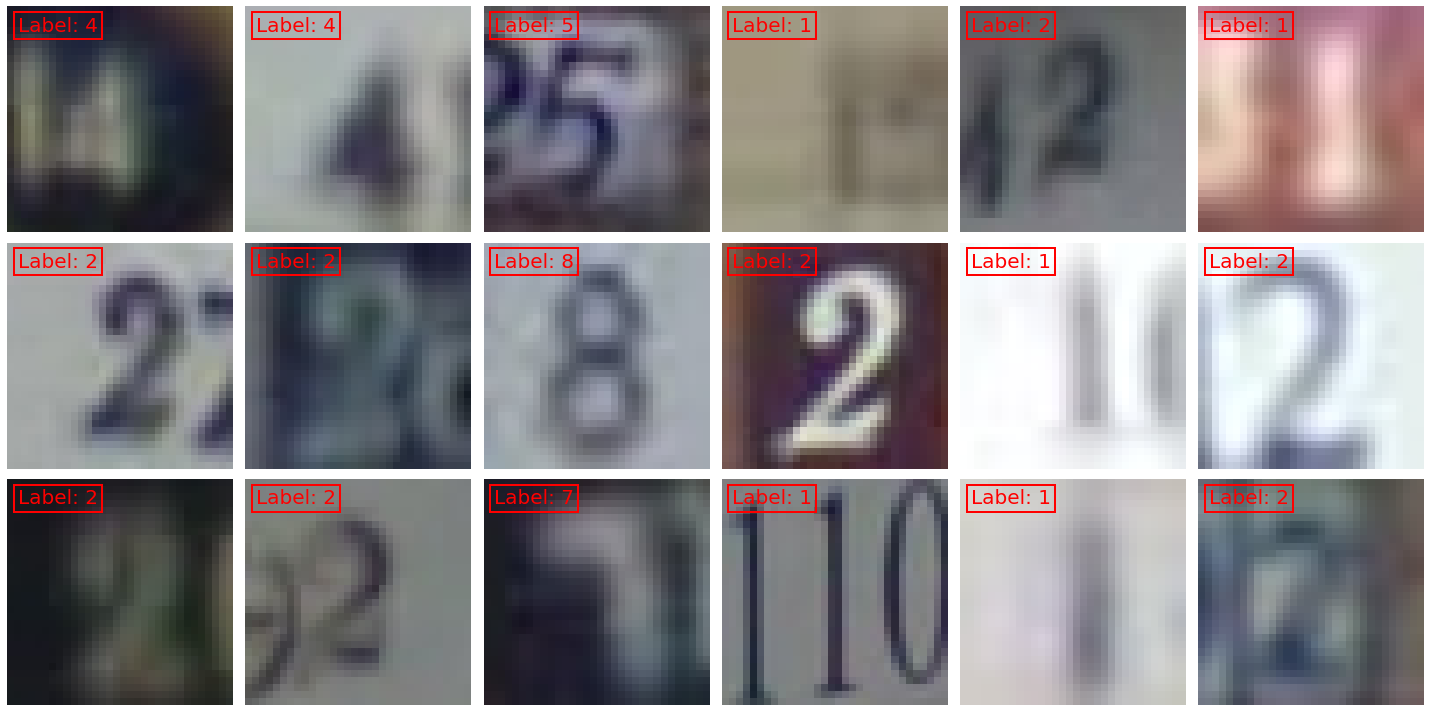

In [3]:
def visualize_image(images, labels, index):
    img = images[:,:,:,index]
    label = labels[index]
    plt.imshow((img))
    plt.text(1, 3, 'Label: {label}'.format(label=label), c = 'red', fontsize= 20,
             bbox=dict(fill=False, edgecolor='red', linewidth=2))
    plt.axis('off')
    

plt.subplots(figsize=(20,10))
split_images, split_labels = load_data('./data','test_01_task1')
for idx, image_index in enumerate(np.random.randint(0, split_images.shape[-1], 18)):
    plt.subplot(3,6,idx+1)
    visualize_image(split_images,
                split_labels,
                image_index)
plt.tight_layout()
plt.show()

Just from looking at the images, we see that some of the house numbers, despite having multiple numbers, have only one label. We will now look at the count of tables.

<AxesSubplot:>

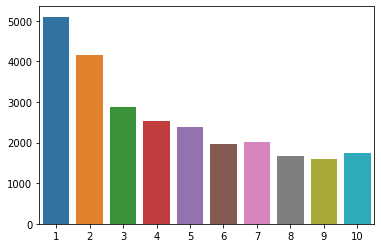

In [104]:
# Labels distribution
%matplotlib inline 

unique_labels, count_labels = np.unique(split_labels, return_counts=True)
sns.barplot(x=unique_labels, y=count_labels)

There is a clear inbalance of labels.

### Model building

Next, we build our model which we called Marci. In this case, we have decided to continue recycling part of the code proposed in the example. Given the limitation to 200k parameters int he model, we have included a simple block of convolutional layers aimed at extracting spatial features from the images. The output of the convolutional block is flattened prior to be fed into the classifier part of the CNN. 

In [4]:
class Marci(pl.LightningModule):
    def __init__(self, 
                 in_features, 
                 hidden_features, 
                 n_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3)
        self.conv3 = nn.Conv2d(16, 8, kernel_size=3)
        self.conv4 = nn.Conv2d(8, 4, kernel_size=3)

        self.layer1 = nn.Linear(24*24*4, hidden_features)
        self.layer2 = nn.Linear(hidden_features, n_classes)
        self.activation = nn.ReLU()
        self.loss = nn.CrossEntropyLoss()
        self.train_accuracy = torchmetrics.Accuracy()
        self.val_accuracy = torchmetrics.Accuracy()
        self.conf_matrix = torchmetrics.ConfusionMatrix(num_classes=n_classes)

    def forward(self, x):
        x_conv = self.conv1(x)
        x_conv = self.conv2(x_conv)
        x_conv = self.conv3(x_conv)
        x_conv = self.conv4(x_conv)
        
        x_flat = torch.flatten(x_conv, start_dim=1)
        h = self.activation(self.layer1(x_flat))
        out = self.layer2(h)
        return out
    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=1e-2)
        return optimizer
    
    def compute_step(self,batch):
        imgs, labels = batch
        # imgs = imgs.view(imgs.size(0), -1)
        label_logits = self.forward(imgs)
        _,label_predictions = torch.max(label_logits, dim=1 )
        return self.loss(label_logits,labels), labels, label_predictions
    
    def training_step(self, train_batch, batch_idx):
        loss, labels, label_predictions = self.compute_step(train_batch)
        self.train_accuracy(label_predictions, labels)
        self.log_dict({"train/loss": loss, 'train/acc' : self.train_accuracy}, 
                  on_step=False, 
                  on_epoch=True, 
                  prog_bar=True)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        loss, labels, label_predictions = self.compute_step(val_batch)
        self.val_accuracy(label_predictions, labels)
        self.log_dict({"val/loss": loss, 'val/acc' : self.val_accuracy}, 
                  on_step=False, 
                  on_epoch=True, 
                  prog_bar=True)
        return loss
    

    def test_step(self, val_batch, batch_idx):
        loss, labels, label_predictions = self.compute_step(val_batch)
        self.val_accuracy(label_predictions, labels)
        self.log_dict({"val/loss": loss, 'val/acc' : self.val_accuracy}, 
                  on_step=False, 
                  on_epoch=True, 
                  prog_bar=True)
        return loss

Now that our classes and functions are defined, we proceed to load the data and create the dataloaders.

In [5]:
# Create dataset
train_data_ex1 = SVHNDataset('./data','train_task1',
                            transform = transforms.ToTensor()
                            )
test_data_ex1 = SVHNDataset('./data','test_task1',
                        transform = transforms.ToTensor())

# Create Dataloader
train_loader = DataLoader(train_data_ex1, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data_ex1, batch_size=64, shuffle=False)   


Loaded SVHN split: train_task1
-------------------------------------
Images Size:  (32, 32, 3)
Split Number of Images: 73257
Split Labels Array Size: (73257,)
Possible Labels:  [ 1  2  3  4  5  6  7  8  9 10]
Loaded SVHN split: test_task1
-------------------------------------
Images Size:  (32, 32, 3)
Split Number of Images: 26032
Split Labels Array Size: (26032,)
Possible Labels:  [ 1  2  3  4  5  6  7  8  9 10]


Then, we create our model and train it. We have modified the trainer to find the optimal learning rate and batch size. 

In [6]:
# Init
hidden_features = 64
n_classes = 10 

# Create model
model = Marci(0, hidden_features, n_classes)

# Train model
tb_logger = pl_loggers.TensorBoardLogger("./logs/")
trainer = pl.Trainer(gpus=1,max_epochs=15,logger = tb_logger)
trainer.fit(model, train_loader, test_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type             | Params
-----------------------------------------------------
0  | conv1          | Conv2d           | 896   
1  | conv2          | Conv2d           | 4.6 K 
2  | conv3          | Conv2d           | 1.2 K 
3  | conv4          | Conv2d           | 292   
4  | layer1         | Linear           | 147 K 
5  | layer2         | Linear           | 650   
6  | activation     | ReLU             | 0     
7  | loss           | CrossEntropyLoss | 0     
8  | train_accuracy | Accuracy         | 0     
9  | val_accuracy   | Accuracy         | 0     
10 | conf_matrix    | ConfusionMatrix  | 0     
-----------------------------------------------------
155 K     Trainable params
0         Non-trainable params
155 K     Total params
0.621     Total estimated model params size (MB

Sanity Checking: 0it [00:00, ?it/s]

/home/vicente/Documents/Other/SDCV_test/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/vicente/Documents/Other/SDCV_test/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

As we can see, the test accuracy has improve by ~20% just by adding a simple convolutional block, reaching a 82.5% of accuracy, while respecting the parameter constraint imposed by the assignment. Like most convolutional models, most parameters belong to the pre-classifier (layer1).

The following tensorboard instance will show us the training performace.

In [8]:
%reload_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6007 (pid 39917), started 0:01:29 ago. (Use '!kill 39917' to kill it.)

The loss curves of both the training and the test set indicate that the learning rate was appropriate. However, there is a lack of loss reduction within the first six epochs of training, suggesting that an weight initialization may reduce the training time.

We will not evaluate the individual accuracy of each class by looking at the confusion matrix.

In [32]:
def eval_model(model,loader):
    model.eval()
    y_pred_list, targets_list = [], []
    for (imgs, targets) in  loader:
        y_pred = model(imgs)
        _,y_pred_label = torch.max(y_pred, dim=1)
        y_pred_list += y_pred_label.detach().numpy().tolist()
        targets_list += targets.detach().numpy().tolist()    

    return(targets_list, y_pred_list)

targets, y_pred_label = eval_model(model, test_loader)

In [47]:
torch.FloatTensor(targets)

confmat = torchmetrics.ConfusionMatrix(num_classes=10)
confmat_res = confmat(torch.IntTensor(targets), torch.IntTensor(y_pred_label))
confmat_res_prop = confmat_res / torch.sum(confmat_res, dim=1)

confmat_res = confmat_res.detach().numpy()
confmat_res_prop = confmat_res_prop.detach().numpy()



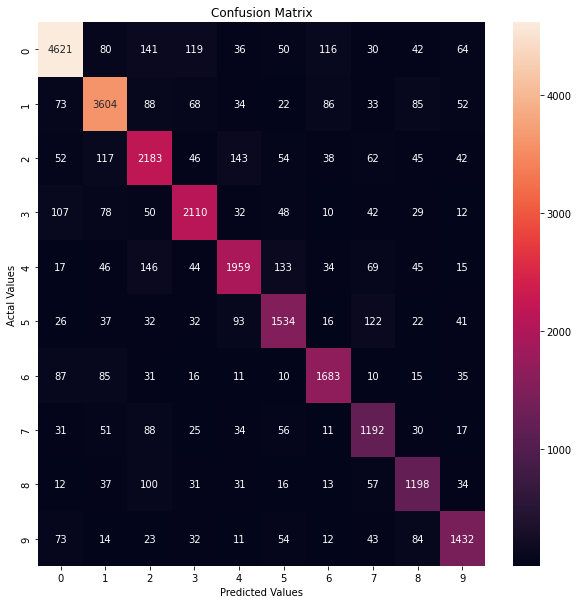

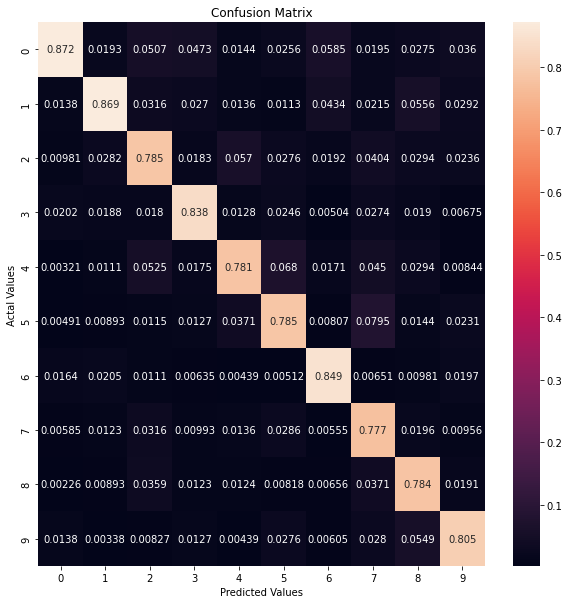

In [55]:


cm = pd.DataFrame(confmat_res,
                     index = np.arange(0,10), 
                     columns = np.arange(0,10))

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

cm = pd.DataFrame(confmat_res_prop,
                     index = np.arange(0,10), 
                     columns = np.arange(0,10))
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='.3g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()


### Alternative solution  
Given that the main constraint of this task is that the model must have less than 200k parameters, an alternative option would be to train a larger model and prune it to reach the desired number of parameters. In the following solution, we implemented a larger model that we called Ellie, which replaced the convolutional layers of Marci with three ResNet convolutional blocks (without adding between blocks). 

In [10]:
class Ellie(pl.LightningModule):
    
    class ConvBloc(nn.Sequential):
        
        def __init__(self, in_channels, out_channels):
            super().__init__()
            self.block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels))
    
    def __init__(self, in_features, hidden_features, n_classes):
        super().__init__()
        self.block1 = self.ConvBloc(3, 16)
        self.block2 = self.ConvBloc(16,32)
        self.block3 = self.ConvBloc(32,64)
        self.layer1 = nn.Linear(65536, hidden_features)
        self.layer2 = nn.Linear(hidden_features, n_classes)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.loss = nn.CrossEntropyLoss()
        self.train_accuracy = torchmetrics.Accuracy()
        self.val_accuracy = torchmetrics.Accuracy()

    def forward(self, x):
        hb1 = self.dropout(self.block1(x))
        hb2 = self.dropout(self.block2(hb1))
        hb3 = self.dropout(self.block3(hb2))
        h = torch.flatten(hb3, start_dim=1)
        h = self.activation(self.layer1(h))
        out = self.layer2(h)
        out = out
        return out
    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=5e-3)
        return optimizer
    
    def compute_step(self,batch):
        imgs, labels = batch
        # imgs = imgs.view(imgs.size(0), -1)
        label_logits = self.forward(imgs)
        _,label_predictions = torch.max(label_logits, dim=1 )
        return self.loss(label_logits,labels), labels, label_predictions
    
    def training_step(self, train_batch, batch_idx):
        loss, labels, label_predictions = self.compute_step(train_batch)
        self.train_accuracy(label_predictions, labels)
        self.log_dict({"train/loss": loss, 'train/acc' : self.train_accuracy}, 
                  on_step=False, 
                  on_epoch=True, 
                  prog_bar=True)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        loss, labels, label_predictions = self.compute_step(val_batch)
        self.val_accuracy(label_predictions, labels)
        self.log_dict({"val/loss": loss, 'val/acc' : self.val_accuracy}, 
                  on_step=False, 
                  on_epoch=True, 
                  prog_bar=True)
        return loss

    def test_step(self, val_batch, batch_idx):
        loss, labels, label_predictions = self.compute_step(val_batch)
        self.val_accuracy(label_predictions, labels)
        self.log_dict({"val/loss": loss, 'val/acc' : self.val_accuracy}, 
                  on_step=False, 
                  on_epoch=True, 
                  prog_bar=True)
        return loss


We proceed to train the model similarly to the previous one. We will also get the weights of the pre-classifier to compare after prunning.

In [33]:
# Create model
model_ellie = Ellie(0,
            hidden_features,
            n_classes)

# Train model
tb_logger = pl_loggers.TensorBoardLogger("./logs/")
trainer = pl.Trainer(gpus=1,max_epochs=10,logger = tb_logger)
trainer.fit(model_ellie, 
        train_loader, 
        test_loader)

ellie_weights = model_ellie.layer1.weight

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | block1         | ConvBloc         | 2.8 K 
1 | block2         | ConvBloc         | 14.0 K
2 | block3         | ConvBloc         | 55.6 K
3 | layer1         | Linear           | 4.2 M 
4 | layer2         | Linear           | 650   
5 | activation     | ReLU             | 0     
6 | dropout        | Dropout          | 0     
7 | loss           | CrossEntropyLoss | 0     
8 | train_accuracy | Accuracy         | 0     
9 | val_accuracy   | Accuracy         | 0     
----------------------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params
17.069    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/vicente/Documents/Other/SDCV_test/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/vicente/Documents/Other/SDCV_test/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

This model achieves a much superior accuracy, reaching around 90% in the validation test. Now, in order to meet the proposed constraints, we globally prune the models' paremeter and evaluate with the test set. We exclude the last linear layer of the model for prunning.

In [34]:
# Prune model 
parameters_to_prune = (
    (model_ellie.block1[0][0], 'weight'),
    (model_ellie.block1[0][3], 'weight'),
    (model_ellie.block2[0][0], 'weight'),
    (model_ellie.block2[0][3], 'weight'),
    (model_ellie.block3[0][0], 'weight'),
    (model_ellie.block3[0][3], 'weight'),
    (model_ellie.layer1, 'weight')
)

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.9527)

# Evaluate pruned model
model_acc = eval_model(model_ellie, test_loader)
print("Test accuracy after prunning: {:.3f}".format(model_acc))

# Get model weights
ellie_weights_pruned = model_ellie.layer1.weight


Test accuracy after prunning: 0.917


Now, we will compare the histogram function of the pre-classifier's parameters before and after prunning.

Text(0.5, 0, 'Layer Weight')

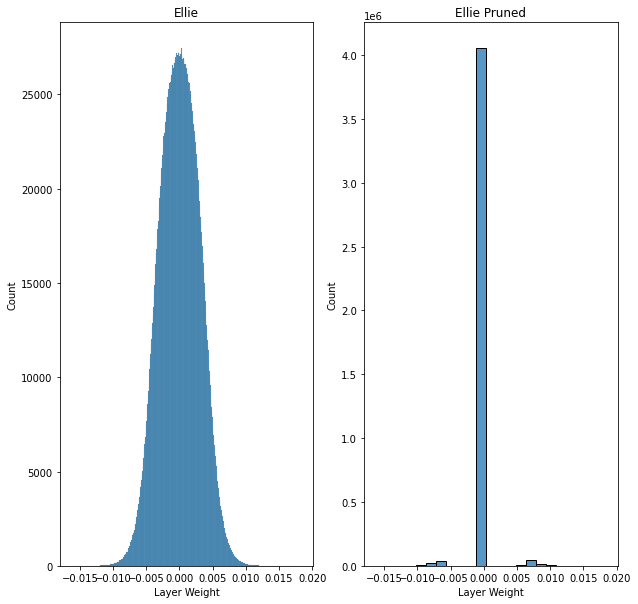

In [91]:
# Create dataframe 
weights_df = pd.DataFrame({'ellie':ellie_weights.detach().numpy().flatten(), 'ellie_pruned':ellie_weights_pruned.detach().numpy().flatten()})

# Plot
%matplotlib inline 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
sns.histplot(weights_df, x='ellie', ax=axes[0])
axes[0].set_title("Ellie")
axes[0].set_xlabel("Layer Weight")
sns.histplot(weights_df, x='ellie_pruned', ax=axes[1])
axes[1].set_title("Ellie Pruned")
axes[1].set_xlabel("Layer Weight")


Clearly, the large majority of weights in the pre-classifier have been set to 0, while maintaining a classification accuracy over 90%. 


**Note:** Pruning does not reduce the size of the CNN, it just sets its weights to 0. Therefore, both the size in memory and the computational time is the same as un-pruned. Unfortunately, neither Pytorch nor Tensorflow have a functional prunning system that reduces the size of the neural network, and seems to be mostly focused to research the impact of pruning in Neural Networks. However, given that most weights of Ellie have been set to 0, the model performance may be improved by substantially reducing the input size to the pre-classifier (either by adding convolutional layers with larger stride, or reducing the number of output channels).

### Conclusions:

Just adding a few convolutional layers to the MLP, has noticeable improved the classification accuracy of the system. Nonetheless, the parameter size constraint limits the possibility to larger and more accurate networks. A suggested solution is to train a larger network, and prune it to reduce the number of paremeters. This is, however, tricky, given that although in theory paremters are "removed", the reality is that layers' weight are set to 0. Thus, the size and computational time of the model is the same as un-pruned. 

There are a few things, that while they have not been included, they may improve the model's accuracy:
- **Image normalization:** normalizing images to a mean of 0 and standard deviation of 1 has shown significant improvements in classification tasks using datasets like ImageNet. Though, this would require to compute the mean and standard deviation of the whole dataset. 
- **Image augmentation:** no dataset augmentation method has been implemented in this case, given the robustness of the model. However, given the enormous variability of images, it may have improved classification. 
- **Other accuracy measures:** since this is a multi-class paradigm, other measures like confusion matrices or per-label-accuracy may have provided a better insight into which categories were harder to correctly classify.